# Description
For each density bin, plot the measured multipoles as well as the fitted Kaiser model with and without a FoG term.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, erf
import time

import inv_cov_funcs as icf
import cat_power_algos as catpk
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')

dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [164]:
# load data multipoles
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fitmodel_densitysplit/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034 and ignore first k bin
possible_kmax = k_full[k_full<=0.343][1:]
# set kmax up to which parameters have been fitted and slice data quantaties
kmax = possible_kmax[21] 
mask = np.full(len(k_full), False)
mask = k_full <= kmax
mask[0] = False 
k = k_full[mask]
Pk_ells = Pk_ells_full[:,:,mask]

# load fitted parameter values
b1 = np.loadtxt("fit_results/NoFoG/b1_fits.txt")
beta = np.loadtxt("fit_results/NoFoG/beta_fits.txt")

b1_damped = np.loadtxt("fit_results/FoG/b1_fits.txt")
beta_damped = np.loadtxt("fit_results/FoG/beta_fits.txt")
sigma_damped = np.loadtxt("fit_results/FoG/sigma_fits.txt")

In [6]:
def Kaiser(theta):
    '''Analytic expression for monopole and quadrupole for pure Kaiser model'''
    b1, beta = theta
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
    
    return model_multipoles
    

def Kaiser_damped(theta):
    '''Analytic expression for monopole and quadrupole for Kaiser model damped by Gaussian FoG'''
    b1, beta, sigma = theta
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = ( 1/(2*(k*sigma)**5) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(3*beta**2+(k*sigma)**4+2*beta*(k*sigma)**2) + 
                                                np.exp(-0.5*(k*sigma)**2)*(-2*beta*(beta+2)*(k*sigma)**3-6*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    model_multipoles[1] = ( -5/(4*(k*sigma)**7) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(-45*beta**2+(k*sigma)**6+(2*beta-3)*(k*sigma)**4+3*(beta-6)*beta*(k*sigma)**2) + 
                                                np.exp(-0.5*(k*sigma)**2)*((4*beta*(beta+2)+6)*(k*sigma)**5+12*beta*(2*beta+3)*(k*sigma)**3+90*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    
    return model_multipoles

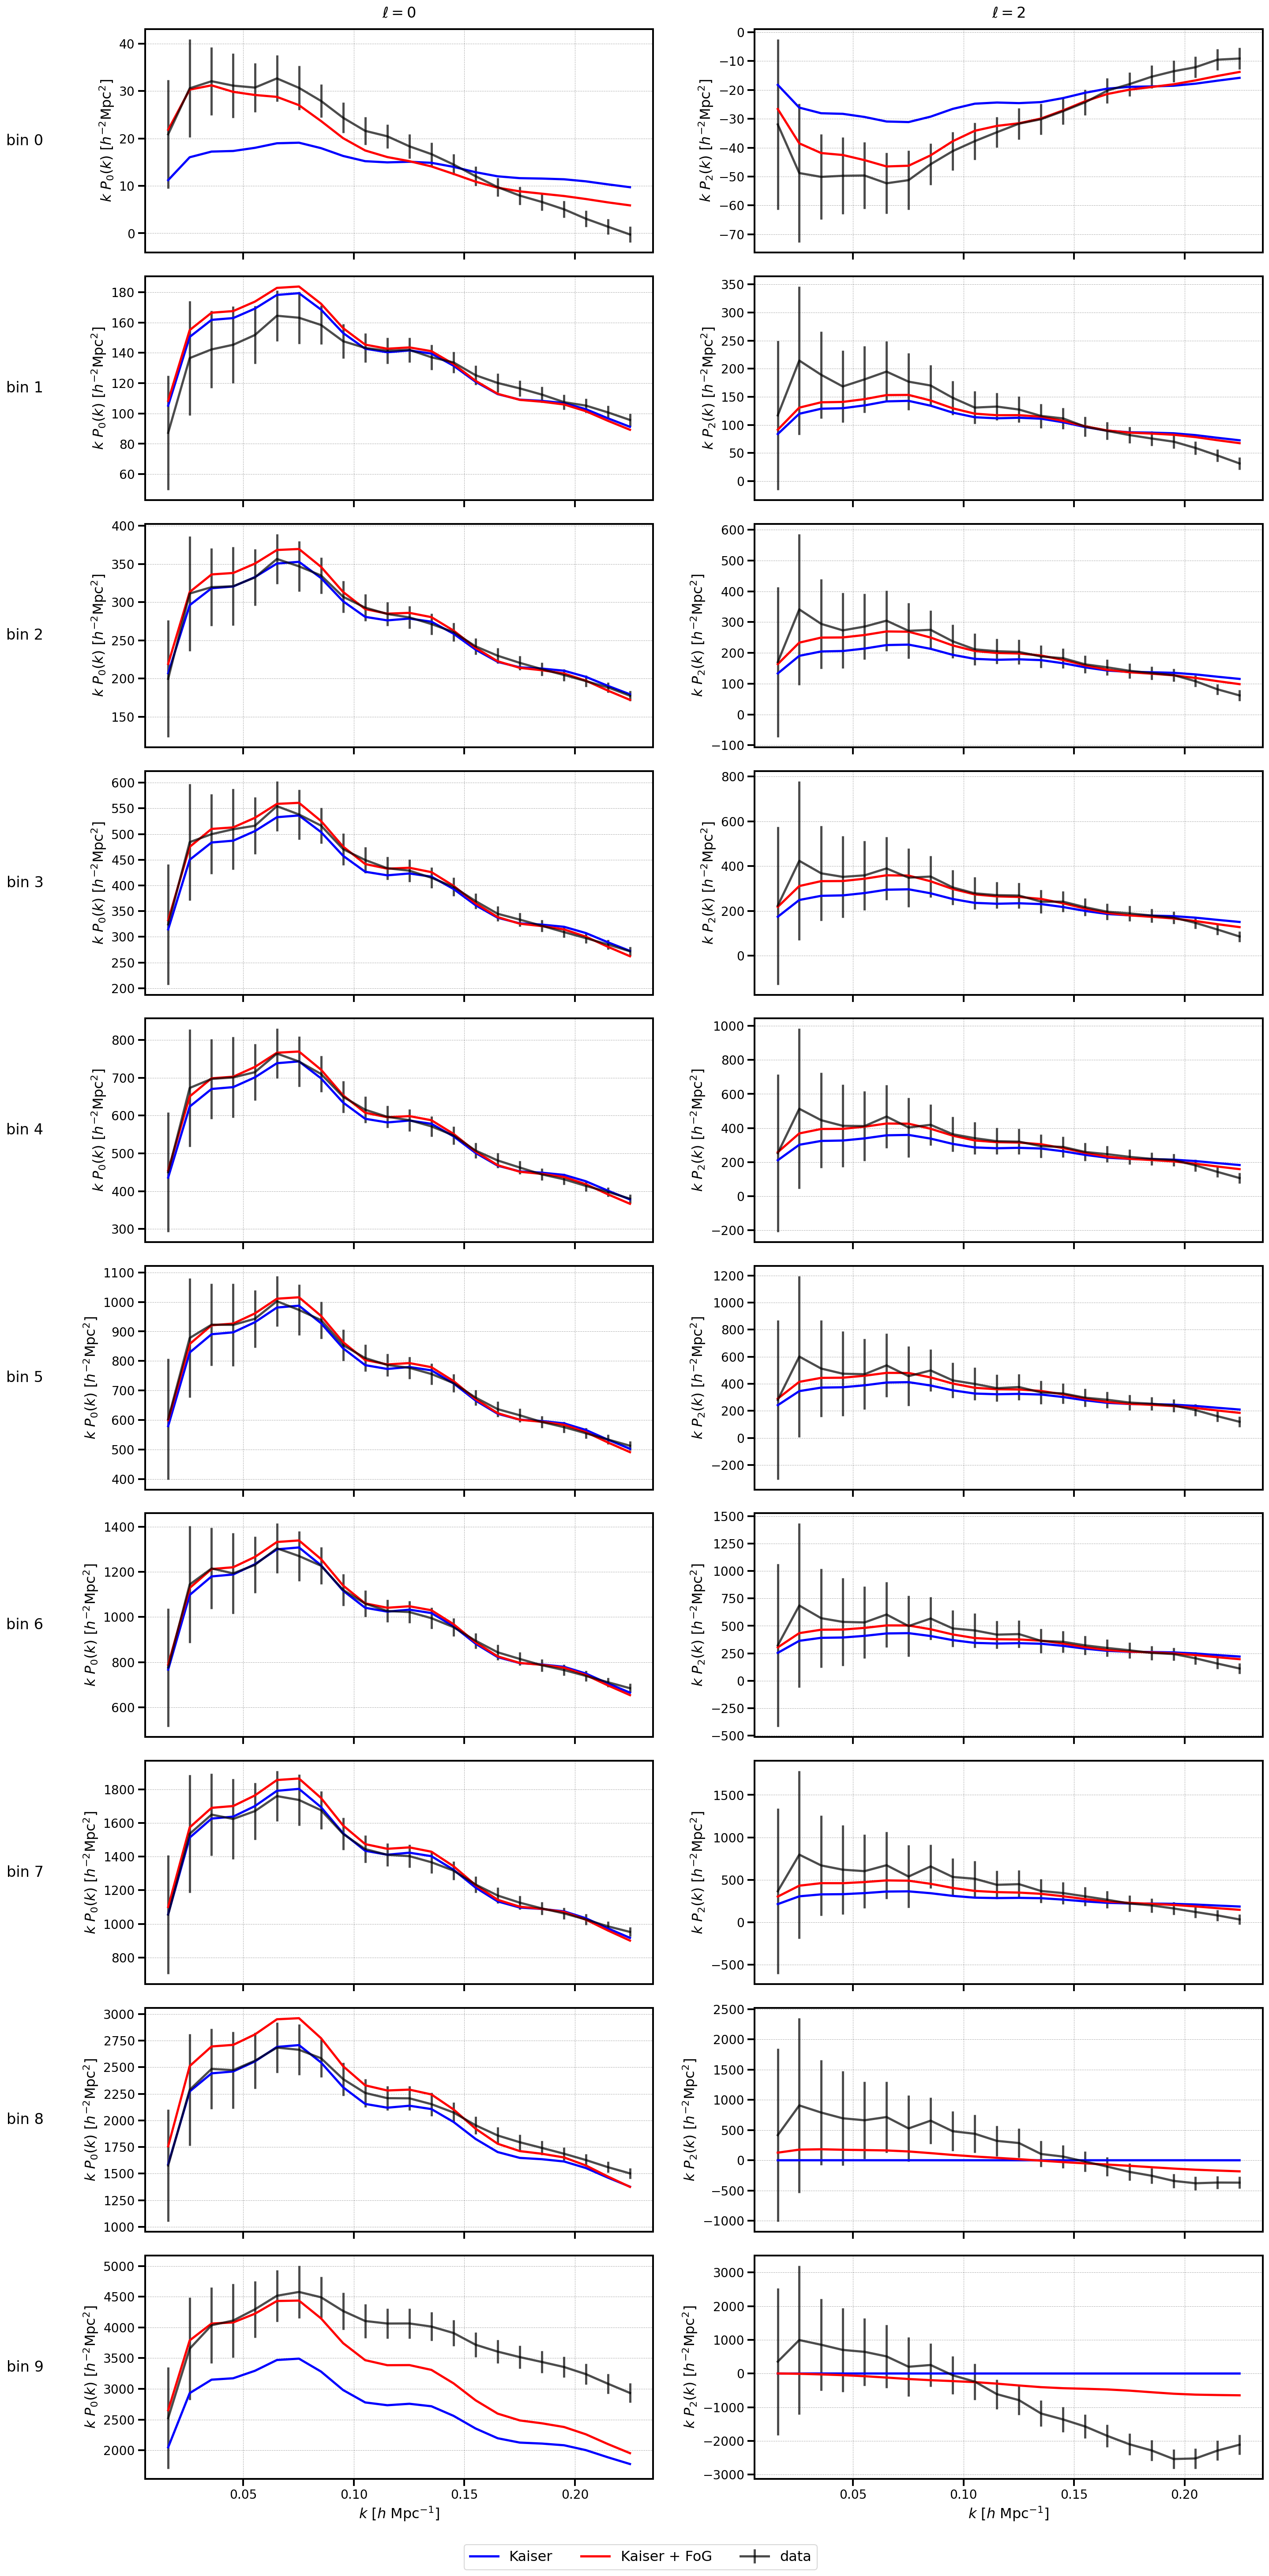

In [165]:
# plot data (with errors) and best fit Kaiser and damped Kaiser for selected density bins
sel = [0,1,2,3,4,5,6,7,8,9] #[0] 

fig, axs = plt.subplots(len(sel), 2, figsize=(20,4*len(sel)), sharex=True)

# assure iteration though axis works when only one density is being plotted
if len(sel) == 1:
    axs = axs.reshape(1,2)

# use idx for iterating axis, i for iterating density bins
for idx, i in enumerate(sel):
    theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    kaiser = Kaiser(theta)
    kaiser_damped = Kaiser_damped(theta_damped)
    
    # get diagonals of inverse covarinace matrix as errors on data
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    cov_mat_sliced = icf.slice_covmat(cov_mat, k_full, kmax)
    errs = np.sqrt(np.diagonal(cov_mat_sliced).reshape((2,-1)))
    
    for l, ell in enumerate(ells):
        axs[idx][l].errorbar(k, k*Pk_ells[i][l], yerr=k*errs[l] ,c='k', alpha=0.7, label='data')
        axs[idx][l].plot(k, k*kaiser[l], c='blue',label='Kaiser')
        axs[idx][l].plot(k, k*kaiser_damped[l], c='red', label='Kaiser + FoG')
        
        if i == sel[-1]:
            axs[idx][l].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        axs[idx][l].set_ylabel(r'$k \ P_{%d}(k)$ [$h^{-2}\mathrm{Mpc}^2$]'%ell)
        
        
cols_txt = [r'$\ell=%d$'%ell for ell in ells]
rows_txt = [r'bin %d'%i for i in sel]

# xy is point to place text in terms of coordinate system xycoords
for ax, col_txt in zip(axs[0], cols_txt):
    ax.annotate(col_txt, xy=(0.5, 1.05), xycoords='axes fraction',
                size='large', ha='center', va='baseline')

for ax, row_txt in zip(axs[:,0], rows_txt):
    ax.annotate(row_txt, xy=(-0.2, 0.5), xycoords='axes fraction',
                size='large', ha='right', va='center')    
   

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=n_ptile)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.show()
#fig.savefig('plots/data_fittedmodels.pdf')

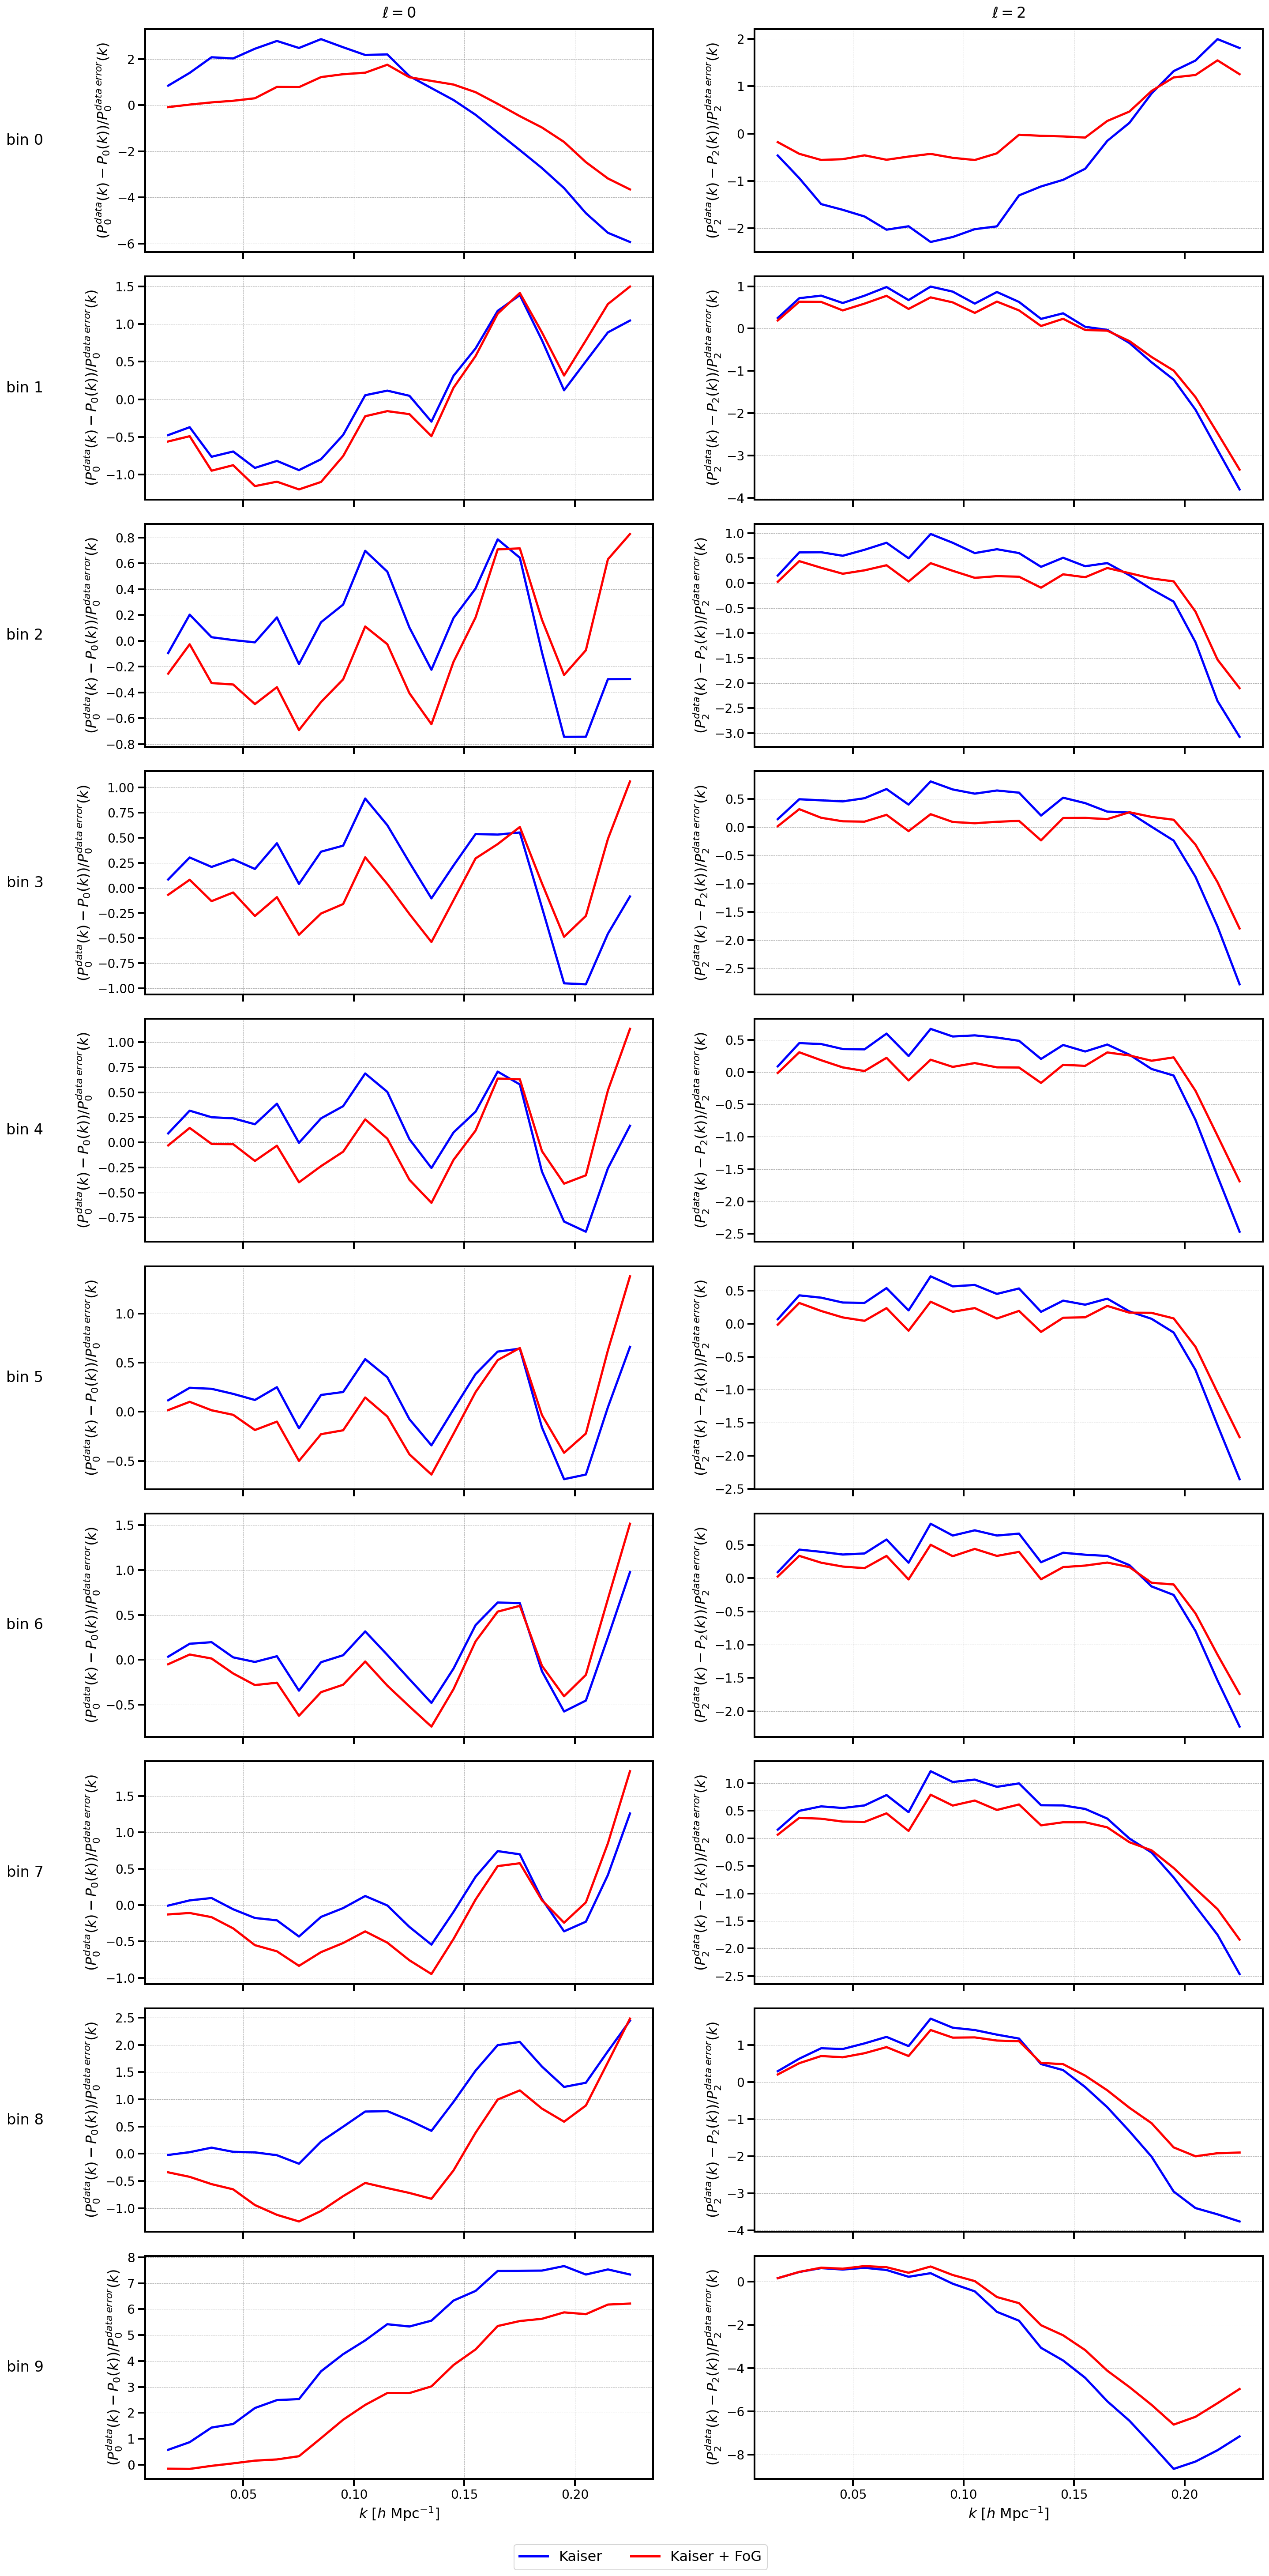

In [166]:
# plot residual between data and models
sel = [0,1,2,3,4,5,6,7,8,9] #[0] 

fig, axs = plt.subplots(len(sel), 2, figsize=(20,4*len(sel)), sharex=True)

# assure iteration though axis works when only one density is being plotted
if len(sel) == 1:
    axs = axs.reshape(1,2)

# use idx for iterating axis, i for iterating density bins
for idx, i in enumerate(sel):
    theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    kaiser = Kaiser(theta)
    kaiser_damped = Kaiser_damped(theta_damped)
    
    # get diagonals of inverse covarinace matrix as errors on data
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    cov_mat_sliced = icf.slice_covmat(cov_mat, k_full, kmax)
    errs = np.sqrt(np.diagonal(cov_mat_sliced).reshape((2,-1)))
    
    for l, ell in enumerate(ells):
        axs[idx][l].plot(k, (Pk_ells[i][l]-kaiser[l])/errs[l], c='blue',label='Kaiser')
        axs[idx][l].plot(k, (Pk_ells[i][l]-kaiser_damped[l])/errs[l], c='red', label='Kaiser + FoG')
        
        if i == sel[-1]:
            axs[idx][l].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        axs[idx][l].set_ylabel(r'$(P_{%d}^{data}(k)-P_{%d}(k))/P_{%d}^{data \: error}(k)$'%(ell,ell,ell))
        
    
cols_txt = [r'$\ell=%d$'%ell for ell in ells]
rows_txt = [r'bin %d'%i for i in sel]

# xy is point to place text in terms of coordinate system xycoords
for ax, col_txt in zip(axs[0], cols_txt):
    ax.annotate(col_txt, xy=(0.5, 1.05), xycoords='axes fraction',
                size='large', ha='center', va='baseline')

for ax, row_txt in zip(axs[:,0], rows_txt):
    ax.annotate(row_txt, xy=(-0.2, 0.5), xycoords='axes fraction',
                size='large', ha='right', va='center')

    
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=n_ptile)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.show()
#fig.savefig('plots/data_fittedmodels_residual.pdf')

### NB
Note: Plotting residuals is more useful then plotting the relative error since it takes the measurement uncertainty into account and avoids division by zero (and sign) issues when the data multipole becomes small. If the residual is between $\pm 1$ we find the model to agree with the measurement to a level of 1 standard deviation. Positive residuals indicate under-predicting while a negative residual indicates over-prediction.

### Range of $k$ and confidence in fit: 
I expect the curves to differ slightly when considering different ranges for $k$ as the plotted model predictions correspond to the values fitted for the upper bound of the $k$ range. For the monopole this expectation manifests itself. However for the quadrupole, we find that the curves change significantly between $k_{max}=0.225$ and $k_{max}=0.342$. So much so that the better performing model is flipped for some bins. This reflects the very large value of reduced $\chi^2$ expressing the limited amount of confidence one should place in the fit. Since a shorter range for $k$ gives a better reduced $\chi^2$, I trust the results for $k_{max}=0.225$ more and hence base the interpretations on them.   

### Interpretation
Generally, the monopole has better agreement than the quadrupole. Overall, the prediction of both models similar which is no surprise at small k since the damping term is approximately 1 and the best-fit parameter values are similar too (see `pre-analyis_fit.ipynb`). Effect of FoG term best visible in quadrupole: Each bin (excluding 0) has some $k^*$ after which both models over-predict significantly. The damping term linders this slightly. The existence of such $k^*$ is expected as it indicates the scale at which the linear model breaks down. A similar threshold is not as clearly visible in the monopole plot, even when considering the full $k$ range.

For the medium density bins (3 - 7 inclusive), we find surprisingly regular dips in the residuals at $k \approx 0.075, 0.13, 0.2$(Monopole only).

When only allowing for small values of $\sigma$ through its prior, the model predictions are not changed, expect for the 0th density bin where the Kaiser + FoG model becomes very similar to the pure Kaiser model.   